In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

import screed

import importlib
import alignplot
import pprint
importlib.reload(alignplot)

from alignplot import StackedDotPlot

## another tara genome, this time with two contaminants

['./genomes/TARA_PSE_MAG_00132.fa']
found queryfile for TARA_PSE_MAG_00132: ./genomes/TARA_PSE_MAG_00132.fa
found targetfile for GCA_001550135.1: ./genomes/GCA_001550135.1_ASM155013v1_genomic.fna
found targetfile for GCA_001641615.1: ./genomes/GCA_001641615.1_ASM164161v1_genomic.fna
running nucmer & show-coords for ./genomes/GCA_001550135.1_ASM155013v1_genomic.fna...
...done! reading output from /var/folders/y6/s1r3q87933s6gjdrtmts1npc0000gq/T/tmph7md2tnl.
running nucmer & show-coords for ./genomes/GCA_001641615.1_ASM164161v1_genomic.fna...
...done! reading output from /var/folders/y6/s1r3q87933s6gjdrtmts1npc0000gq/T/tmpoeac069y.
shared w/GCA_001550135.1: 3652.8kb
shared w/GCA_001641615.1: 3625.3kb


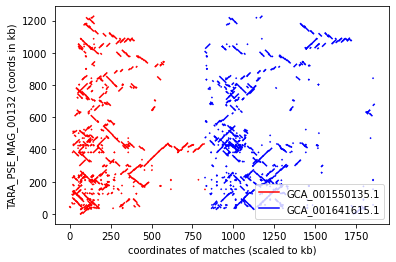

In [16]:
dotplot = StackedDotPlot('TARA_PSE_MAG_00132', ('GCA_001550135.1', 'GCA_001641615.1'), 'list.csv', './genomes')
#dotplot.use_mashmap = True
x = dotplot()

['./genomes/TARA_ANW_MAG_00083.fa']
found queryfile for TARA_ANW_MAG_00083: ./genomes/TARA_ANW_MAG_00083.fa
found targetfile for GCA_002171995.1: ./genomes/GCA_002171995.1_ASM217199v1_genomic.fna
['./genomes/GCA_002171995.1_ASM217199v1_genomic.fna']
found queryfile for GCA_002171995.1: ./genomes/GCA_002171995.1_ASM217199v1_genomic.fna
found targetfile for TARA_ANW_MAG_00083: ./genomes/TARA_ANW_MAG_00083.fa
running mashmap...
running mashmap -q ./genomes/GCA_002171995.1_ASM217199v1_genomic.fna -r ./genomes/TARA_ANW_MAG_00083.fa -o /var/folders/y6/s1r3q87933s6gjdrtmts1npc0000gq/T/tmp3va23zjf/mashmap.out --pi 95
...done! reading output from /var/folders/y6/s1r3q87933s6gjdrtmts1npc0000gq/T/tmp3va23zjf/mashmap.out.
shared w/TARA_ANW_MAG_00083: 408.4kb


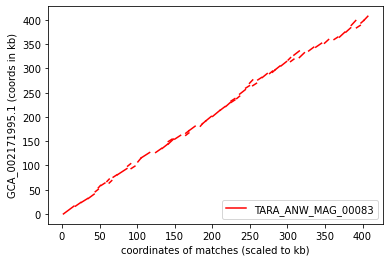

In [44]:
dotplot = StackedDotPlot('TARA_ANW_MAG_00083', ('GCA_002171995.1',), 'list.csv', './genomes')
dotplot = StackedDotPlot('GCA_002171995.1', ('TARA_ANW_MAG_00083',), 'list.csv', './genomes')

dotplot.use_mashmap = True
x = dotplot()

['./genomes/GCA_001550135.1_ASM155013v1_genomic.fna']
found queryfile for GCA_001550135.1: ./genomes/GCA_001550135.1_ASM155013v1_genomic.fna
found targetfile for TARA_PSE_MAG_00132: ./genomes/TARA_PSE_MAG_00132.fa
found targetfile for GCA_001641615.1: ./genomes/GCA_001641615.1_ASM164161v1_genomic.fna
running nucmer & show-coords for ./genomes/TARA_PSE_MAG_00132.fa...
...done! reading output from /var/folders/y6/s1r3q87933s6gjdrtmts1npc0000gq/T/tmpp6yvhw1s.
running nucmer & show-coords for ./genomes/GCA_001641615.1_ASM164161v1_genomic.fna...
...done! reading output from /var/folders/y6/s1r3q87933s6gjdrtmts1npc0000gq/T/tmpee6fdugj.
shared w/TARA_PSE_MAG_00132: 3621.4kb
shared w/GCA_001641615.1: 4251.9kb


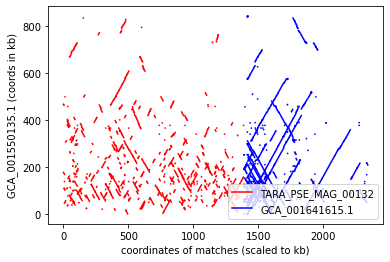

In [50]:
dotplot = StackedDotPlot('GCA_001550135.1', ('TARA_PSE_MAG_00132', 'GCA_001641615.1'), 'list.csv', './genomes')
#dotplot.use_mashmap = True
x = dotplot()

['./genomes/GCA_003220225.1_ASM322022v1_genomic.fna']
found queryfile for GCA_003220225.1: ./genomes/GCA_003220225.1_ASM322022v1_genomic.fna
found targetfile for GCA_003222275.1: ./genomes/GCA_003222275.1_ASM322227v1_genomic.fna
running nucmer & show-coords for ./genomes/GCA_003222275.1_ASM322227v1_genomic.fna...
...done! reading output from /var/folders/y6/s1r3q87933s6gjdrtmts1npc0000gq/T/tmpnsj2135w.
shared w/Acidobacteria bacterium: 635.4kb


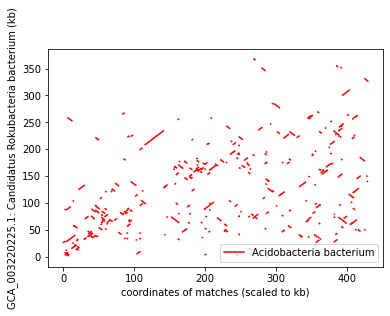

In [66]:
dotplot = StackedDotPlot('GCA_003220225.1',
                         ['GCA_003222275.1',],
                         'list.csv', './genomes')
_ = dotplot()

['./genomes/GCA_003222275.1_ASM322227v1_genomic.fna']
found queryfile for GCA_003222275.1: ./genomes/GCA_003222275.1_ASM322227v1_genomic.fna
found targetfile for GCA_003222275.1: ./genomes/GCA_003222275.1_ASM322227v1_genomic.fna
running nucmer & show-coords for ./genomes/GCA_003222275.1_ASM322227v1_genomic.fna...
...done! reading output from /var/folders/y6/s1r3q87933s6gjdrtmts1npc0000gq/T/tmp_d_z594a.
shared w/Acidobacteria bacterium: 6883.5kb


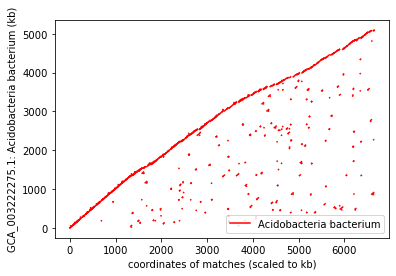

In [74]:
dotplot = StackedDotPlot('GCA_003222275.1',
                         ['GCA_003222275.1',],
                         'list.csv', './genomes')
_ = dotplot()

In [75]:
regions = list(dotplot.results.values())[0]

sorted_regions = []
for region in regions:
    pident = region.pident
    fident = pident / 100
    f_match = (region.qend - region.qstart) / region.qsize
    contig_ani = f_match * fident
    sorted_regions.append((contig_ani, f_match, region))

sorted_regions.sort(reverse=True)
#pprint.pprint(sorted_regions[:3])
#pprint.pprint(sorted_regions[-3:])

In [76]:
kb_above_95 = 0
total_kb = 0

ani95_names = set()
ani95_lengths = []
for (contig_ani, _, region) in sorted_regions:
    size = region.qend - region.qstart
    if contig_ani >= .95:
        kb_above_95 += size # note: uniqify
        ani95_names.add(region.query)
        ani95_lengths.append((region.qsize, region))
    total_kb += size

print(f'{kb_above_95:.1f} kb in contigs > 95% ANI, of {total_kb:.1f} kb total alignments')
print(f'{kb_above_95/total_kb*100:.1f}% of shared sequence in contigs > 95% ANI')

6822.3 kb in contigs > 95% ANI, of 6883.5 kb total alignments
99.1% of shared sequence in contigs > 95% ANI


In [77]:
import screed

sum_bp = 0
all_sizes = []
for record in screed.open(dotplot.queryfile):
    sum_bp += len(record.sequence)
    all_sizes.append((record.name.split()[0], len(record.sequence) / 1e3))
        
print(dotplot.queryfile, sum_bp)
sum_kb = sum_bp / 1e3

print(f'{kb_above_95/sum_kb*100:.1f}% of genome {dotplot.q_acc} in contigs shared > 95% ANI')

./genomes/GCA_003222275.1_ASM322227v1_genomic.fna 6756227
101.0% of genome GCA_003222275.1 in contigs shared > 95% ANI


In [78]:
x = []
y = []
ani95_lengths.sort()
sofar = 0
for (contig_size, region) in ani95_lengths:
    sofar += contig_size
    f_total_ani95 = sofar / kb_above_95
    x.append(sofar)
    y.append(f_total_ani95)
    
for name, contig_size in all_sizes:
    if name not in ani95_names:
        y.append(f_total_ani95)
        sofar += contig_size
        x.append(sofar)

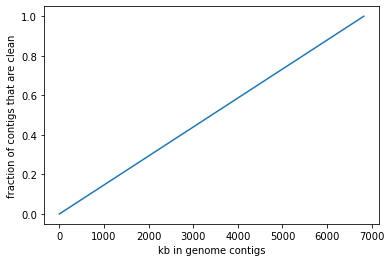

In [79]:
plt.plot(x, y)
plt.xlabel('kb in genome contigs')
plt.ylabel('fraction of contigs that are clean')
plt.savefig('/tmp/acido-target.png')